In [245]:
import os, sys, glob, json, shutil
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import src.params as params

In [229]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
%aimport src.dataloader

# Sanity check on web-scraped TSV files

In [6]:
tsv_files = glob.glob("../data/tsv/*/*.tsv")
num_lines = lambda x: sum(1 for line in open(x))

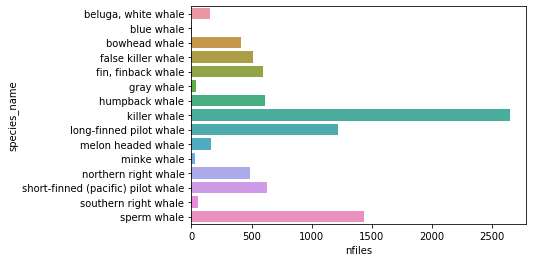

In [26]:
# Quick check on number of files
file_stats = {"species_name":[],"year":[],"nfiles":[]}
for file in tsv_files:
    file_stats["species_name"].append(os.path.basename(os.path.dirname(file)))
    file_stats["year"].append(file.rsplit('_',1)[1].split('.')[0])
    file_stats["nfiles"].append(num_lines(file))
df = pd.DataFrame.from_dict(file_stats)
counts = df.groupby("species_name").sum()
sns.barplot(x='nfiles',y='species_name',data=counts.reset_index())

In [114]:
# Join all TSV files and metadata
tsv_files = glob.glob("../data/tsv/killer whale/*.tsv")
df_list = []
for tsv_file in tsv_files:
    df_list.append(pd.read_csv(tsv_file,sep='\t'))
df = pd.concat(df_list)

In [ ]:
# for ref see pg. 20 here https://cis.whoi.edu/science/B/whalesounds/WHOI-92-31.pdf 
# cols to join: RN, CU, SR, CS
with open("../data/tsv/killer whale/metadata.json") as f: metadata = json.load(f)
mtd_df = pd.DataFrame.from_dict(metadata,orient="index")
mtd_df = mtd_df.fillna(0).astype({"SR":int,"CS":float},errors="ignore")
df = pd.DataFrame.merge(df,mtd_df[["RN","CU","SR","CS"]],left_on="metadata",right_index=True)
df["wav_id"] = df.RN.apply(lambda x: x[:5])

In [85]:
mtd_df.ST.unique()

array(['FMBE7A | Squeal  BE7A', 'FMBE7A | Squeals  BE7A',
       'CHBE7A | Chirps  BE7A',
       'FMBE7A | CHBE7A | Squeal  BE7A | Chirp  BE7A',
       'NLBE7A | BSBE7A | Calls  BE7A | Clicks  BE7A',
       'NLBE7A | Call  BE7A',
       'FMBE7A | BSBE7A | Calls  BE7A | Clicks  BE7A',
       'NLBE7A | Calls  BE7A',
       'NLBE7A | BSBE7A | Call  BE7A | Clicks  BE7A',
       'BSBE7A | NLBE7A | Clicks  BE7A | Call  BE7A',
       'BSBE7A | Clicks  BE7A',
       'FMBE7A | BSBE7A | Call  BE7A | Clicks  BE7A',
       'FMBE7A | Call  BE7A',
       'BSBE7A | FMBE7A | PUBE7A | Click  BE7A | Squeal  BE7A',
       'BSBE7A | Click  BE7A', 'PUBE7A | BSX | Squeal  BE7A | Ship  X',
       'FMBE7A | PUBE7A | Squeal  BE7A',
       'BSBE7A | FMBE7A | PUBE7A | Clicks  BE7A | Squeal  BE7A',
       'BSBE7A | FMBE7A | PUBE7A | NSBE7A | Click  BE7A | Squeal  BE7A',
       'FMBE7A | PUBE7A | NSBE7A | Squeal  BE7A', 'PUBE7A | Squeal  BE7A',
       'FMBE7A | PUBE7A | BSX | Squeal  BE7A | Ship  X',
       'FMBE7

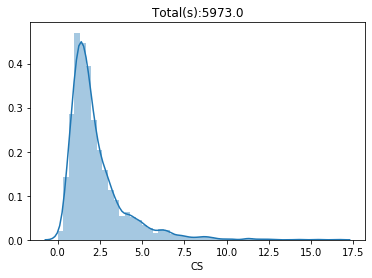

In [107]:
total_s = df.CS.sum()
plt.title("Total(s):"+str(round(total_s)))
sns.distplot(df.CS)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(y="wav_id",x="CU",data=df.groupby("wav_id").CU.count().reset_index(),orient="h")

In [137]:
df.to_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t',index=False)

# Preparing scraped TSV

In [4]:
time_to_s = lambda x: x.hour*3600+x.minute*60+x.second+x.microsecond/1e6
def parse_cut_time(x):
    xs = x.split()
    if len(xs)==1:
        return float(xs[0])
    else:
        if xs[1][0]=='B':
            try:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S.%f").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            except Exception:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            return time_to_s(t1) if t1<t2 else time_to_s(t2)

def prepare_allcuts_df(df,master_wav_ids):
    df = df.copy()
    df['start_time_s'] = 0.0
    df['duration_s'] = pd.to_datetime(df.CS,unit='s').dt.time.apply(time_to_s)
    df['wav_filename'] = df.audio.apply(lambda x: Path(x).stem+".wav")
    for master_wav_id in master_wav_ids:
        df.loc[
            df.wav_id==master_wav_id,'start_time_s'
        ] = df.loc[df.wav_id==master_wav_id].CU.apply(parse_cut_time)
        df.loc[
            df.wav_id==master_wav_id,'wav_filename'
        ] = df.loc[df.wav_id==master_wav_id].wav_id.apply(lambda x: str(x)+".wav")
    print("Length before dropping",len(df))
    df = df.drop_duplicates(['wav_filename','start_time_s','duration_s']).sort_values(by=['wav_filename','start_time_s'])
    print("Length after dropping",len(df))
    return df[['wav_filename','start_time_s','duration_s','location','date']].reset_index(drop=True)

In [5]:
# create TSV in final format for training data
df = pd.read_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t')
master_ids = set([ int(Path(p).stem) for p in os.listdir("../data/wavmaster/") if len(Path(p).stem)==5 ])
df = prepare_allcuts_df(df,master_ids)
df.to_csv("../train_data/all.tsv",sep='\t',index=False)

Length before dropping 2647
Length after dropping 2639


## Create train/dev split

In [19]:
df = pd.read_csv("../train_data/all.tsv",sep='\t')
print(len(df))
df1 = df.copy()
df1['master_wav'] = df1.wav_filename.apply(lambda x: Path(x).stem[:5] )
df1.head()

2639


,wav_filename,start_time_s,duration_s,location,date,master_wav
0,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
2,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
3,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
4,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012


Totally 65 master wav files


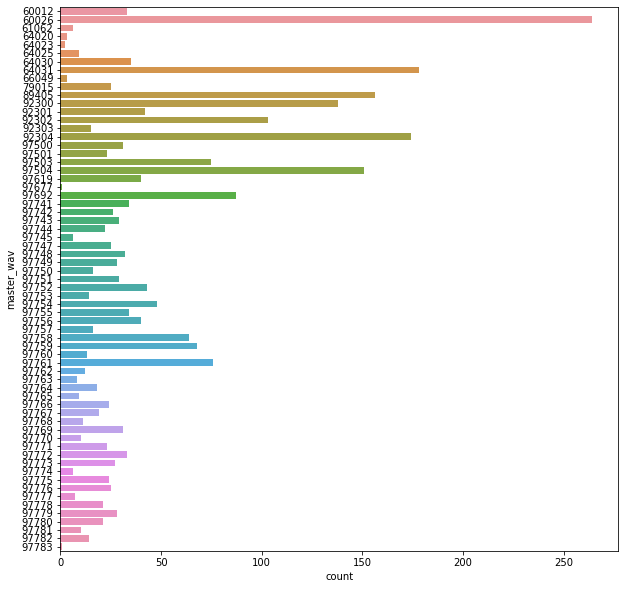

In [20]:
print("Totally",len(set(df1.master_wav)),"master wav files")
plt.figure(figsize=(10,10))
sns.countplot(y=df1.master_wav)

In [46]:
## Choose 1/10 labelled master wavs and randomly choose 6 others 
labelled_master_wavs = ['60012',
 '60026',
 '61062',
 '64020',
 '64023',
 '64025',
 '64030',
 '64031',
 '66049',
 '79015']
dev_master_wavs = ["60012","92303","97745","97753","97768","97781"]
# unlabelled_master_wavs = set(df1.master_wav) - set(labelled_master_wavs)
# np.random.seed(3)
# dev_master_wavs.extend(np.random.choice(list(unlabelled_master_wavs),4,replace=False))
dev_master_wavs

['60012', '92303', '97745', '97753', '97768', '97781']

In [47]:
train_df = df1[ ~df1.master_wav.isin(dev_master_wavs) ].sort_values(['wav_filename','start_time_s']).reset_index(drop=True)
dev_df = df1[ df1.master_wav.isin(dev_master_wavs) ].sort_values(['wav_filename','start_time_s']).reset_index(drop=True)

In [48]:
print(len(train_df))
print(len(dev_df))
train_df.to_csv("../train_data/train.tsv",sep='\t',index=False)
dev_df.to_csv("../train_data/dev.tsv",sep='\t',index=False)

2550
89


# Testing out Dataloader

In [76]:
%aimport dataloader
import params
from IPython.display import display, Audio

In [50]:
## Try out dataset class with all wav files 
df = pd.read_csv("../train_data/train.tsv",sep='\t')
df.head()

,wav_filename,start_time_s,duration_s,location,date,master_wav
0,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
2,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
3,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012
4,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",28-Oct-1960,60012


In [53]:
wav_dataset = dataloader.AudioFileDataset("../train_data/wav","../train_data/train.tsv")

Loading file: 60026.wav
Loading file: 61062.wav
Loading file: 64020.wav
Loading file: 64023.wav
Loading file: 64025.wav
Loading file: 64030.wav
Loading file: 64031.wav
Loading file: 66049.wav
Loading file: 79015.wav
Loading file: 89405023.wav
Loading file: 894050C0.wav
Loading file: 894050C1.wav
Loading file: 894050C2.wav
Loading file: 894050C3.wav
Loading file: 894050C4.wav
Loading file: 894050C5.wav
Loading file: 894050C6.wav
Loading file: 894050C7.wav
Loading file: 894050C8.wav
Loading file: 894050C9.wav
Loading file: 894050CA.wav
Loading file: 894050CB.wav
Loading file: 894050CC.wav
Loading file: 894050CD.wav
Loading file: 894050CE.wav
Loading file: 894050CF.wav
Loading file: 894050CG.wav
Loading file: 894050CH.wav
Loading file: 894050CI.wav
Loading file: 894050CJ.wav
Loading file: 894050CK.wav
Loading file: 894050CL.wav
Loading file: 894050CM.wav
Loading file: 894050CN.wav
Loading file: 894050CP.wav
Loading file: 894050CQ.wav
Loading file: 894050CR.wav
Loading file: 894050CS.wav
L

Loading file: 9230100Q.wav
Loading file: 9230100R.wav
Loading file: 9230100T.wav
Loading file: 9230100U.wav
Loading file: 9230100V.wav
Loading file: 9230100W.wav
Loading file: 9230100X.wav
Loading file: 9230100Y.wav
Loading file: 9230100Z.wav
Loading file: 92301010.wav
Loading file: 92301011.wav
Loading file: 92301012.wav
Loading file: 92301013.wav
Loading file: 92301014.wav
Loading file: 92301015.wav
Loading file: 92301016.wav
Loading file: 92301017.wav
Loading file: 92302001.wav
Loading file: 92302002.wav
Loading file: 92302003.wav
Loading file: 92302004.wav
Loading file: 92302005.wav
Loading file: 92302006.wav
Loading file: 92302007.wav
Loading file: 92302008.wav
Loading file: 92302009.wav
Loading file: 9230200A.wav
Loading file: 9230200B.wav
Loading file: 9230200C.wav
Loading file: 9230200D.wav
Loading file: 9230200E.wav
Loading file: 9230200F.wav
Loading file: 9230200G.wav
Loading file: 9230200H.wav
Loading file: 9230200I.wav
Loading file: 9230200J.wav
Loading file: 9230200K.wav
L

Loading file: 9750000T.wav
Loading file: 9750000U.wav
Loading file: 9750000V.wav
Loading file: 97501001.wav
Loading file: 97501002.wav
Loading file: 97501003.wav
Loading file: 97501004.wav
Loading file: 97501005.wav
Loading file: 97501006.wav
Loading file: 97501007.wav
Loading file: 97501008.wav
Loading file: 97501009.wav
Loading file: 9750100A.wav
Loading file: 9750100B.wav
Loading file: 9750100C.wav
Loading file: 9750100D.wav
Loading file: 9750100E.wav
Loading file: 9750100F.wav
Loading file: 9750100G.wav
Loading file: 9750100H.wav
Loading file: 9750100I.wav
Loading file: 9750100J.wav
Loading file: 9750100K.wav
Loading file: 9750100L.wav
Loading file: 9750100M.wav
Loading file: 9750100N.wav
Loading file: 97503001.wav
Loading file: 97503002.wav
Loading file: 97503003.wav
Loading file: 97503004.wav
Loading file: 97503005.wav
Loading file: 97503006.wav
Loading file: 97503007.wav
Loading file: 97503008.wav
Loading file: 97503009.wav
Loading file: 9750300A.wav
Loading file: 9750300B.wav
L

Loading file: 9769200X.wav
Loading file: 9769200Y.wav
Loading file: 9769200Z.wav
Loading file: 97692011.wav
Loading file: 97692012.wav
Loading file: 97692013.wav
Loading file: 97692014.wav
Loading file: 97692015.wav
Loading file: 97692016.wav
Loading file: 97692017.wav
Loading file: 97692018.wav
Loading file: 97692019.wav
Loading file: 9769201A.wav
Loading file: 9769201B.wav
Loading file: 9769201C.wav
Loading file: 9769201D.wav
Loading file: 9769201E.wav
Loading file: 9769201F.wav
Loading file: 9769201G.wav
Loading file: 9769201I.wav
Loading file: 9769201J.wav
Loading file: 9769201K.wav
Loading file: 9769201L.wav
Loading file: 9769201M.wav
Loading file: 9769201N.wav
Loading file: 9769201O.wav
Loading file: 9769201P.wav
Loading file: 9769201Q.wav
Loading file: 9769201R.wav
Loading file: 9769201S.wav
Loading file: 9769201T.wav
Loading file: 9769201U.wav
Loading file: 9769201V.wav
Loading file: 9769201W.wav
Loading file: 9769201X.wav
Loading file: 9769201Y.wav
Loading file: 9769201Z.wav
L

Loading file: 9775200U.wav
Loading file: 9775200V.wav
Loading file: 9775200W.wav
Loading file: 9775200X.wav
Loading file: 9775200Y.wav
Loading file: 9775200Z.wav
Loading file: 97752010.wav
Loading file: 97752011.wav
Loading file: 97752012.wav
Loading file: 97752013.wav
Loading file: 97752014.wav
Loading file: 97752015.wav
Loading file: 97752016.wav
Loading file: 97752017.wav
Loading file: 97754001.wav
Loading file: 97754002.wav
Loading file: 97754003.wav
Loading file: 97754004.wav
Loading file: 97754005.wav
Loading file: 97754006.wav
Loading file: 97754007.wav
Loading file: 97754008.wav
Loading file: 97754009.wav
Loading file: 9775400A.wav
Loading file: 9775400B.wav
Loading file: 9775400C.wav
Loading file: 9775400D.wav
Loading file: 9775400E.wav
Loading file: 9775400F.wav
Loading file: 9775400G.wav
Loading file: 9775400H.wav
Loading file: 9775400I.wav
Loading file: 9775400J.wav
Loading file: 9775400K.wav
Loading file: 9775400L.wav
Loading file: 9775400M.wav
Loading file: 9775400N.wav
L

Loading file: 9776100E.wav
Loading file: 9776100F.wav
Loading file: 9776100G.wav
Loading file: 9776100H.wav
Loading file: 9776100I.wav
Loading file: 9776100J.wav
Loading file: 9776100K.wav
Loading file: 9776100L.wav
Loading file: 9776100M.wav
Loading file: 9776100N.wav
Loading file: 9776100O.wav
Loading file: 9776100P.wav
Loading file: 9776100Q.wav
Loading file: 9776100R.wav
Loading file: 9776100S.wav
Loading file: 9776100T.wav
Loading file: 9776100U.wav
Loading file: 9776100V.wav
Loading file: 9776100W.wav
Loading file: 9776100X.wav
Loading file: 9776100Y.wav
Loading file: 9776100Z.wav
Loading file: 97761010.wav
Loading file: 97761011.wav
Loading file: 97761012.wav
Loading file: 97761013.wav
Loading file: 97761014.wav
Loading file: 97761015.wav
Loading file: 97761016.wav
Loading file: 97761017.wav
Loading file: 97761018.wav
Loading file: 97761019.wav
Loading file: 9776101A.wav
Loading file: 9776101B.wav
Loading file: 9776101C.wav
Loading file: 9776101D.wav
Loading file: 9776101E.wav
L

Loading file: 9777600A.wav
Loading file: 9777600B.wav
Loading file: 9777600C.wav
Loading file: 9777600D.wav
Loading file: 9777600E.wav
Loading file: 9777600F.wav
Loading file: 9777600G.wav
Loading file: 9777600H.wav
Loading file: 9777600I.wav
Loading file: 9777600J.wav
Loading file: 9777600K.wav
Loading file: 9777600L.wav
Loading file: 9777600M.wav
Loading file: 9777600N.wav
Loading file: 9777600O.wav
Loading file: 9777600P.wav
Loading file: 97777001.wav
Loading file: 97777002.wav
Loading file: 97777003.wav
Loading file: 97777004.wav
Loading file: 97777005.wav
Loading file: 97777006.wav
Loading file: 97777007.wav
Loading file: 97778002.wav
Loading file: 97778003.wav
Loading file: 97778004.wav
Loading file: 97778005.wav
Loading file: 97778006.wav
Loading file: 97778007.wav
Loading file: 97778008.wav
Loading file: 97778009.wav
Loading file: 9777800A.wav
Loading file: 9777800B.wav
Loading file: 9777800C.wav
Loading file: 9777800D.wav
Loading file: 9777800E.wav
Loading file: 9777800F.wav
L

Total dataset size: 6186


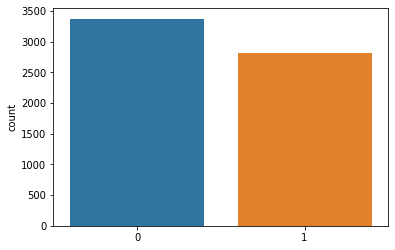

In [54]:
print("Total dataset size:",len(wav_dataset))
labels = [l[2] for l in wav_dataset.windows]
sns.countplot(labels)

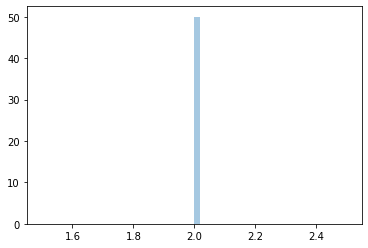

In [474]:
# get durations of windows 
durations_s = []
for w in wav_dataset.windows:
    sr = w[-1].sr
    durations_s.append((w[1]-w[0])/sr)
sns.distplot(durations_s)

In [476]:
# get sampling rate of windows 
sampling_rates = []
for w in wav_dataset.windows:
    sampling_rates.append(w[-1].sr)
set(sampling_rates)

{20000}

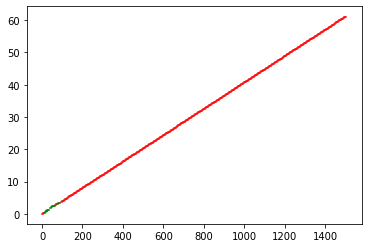

In [45]:
wav_dataset.plot_for_debug("79015.wav",'windows')

In [72]:
idx = np.random.choice(len(wav_dataset))
_, label = wav_dataset[idx]
print("Idx:",idx,"Label",label)

Idx: 4213 Label 1


In [73]:
wav_dataset.get_mode = 'audio'
sample, label = wav_dataset[idx]
Audio(sample,rate=wav_dataset.sr)

(96, 64)


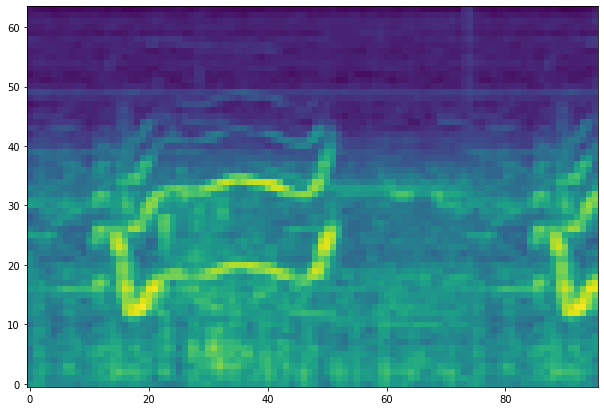

In [74]:
wav_dataset.get_mode = 'mel_spec'
mel_spec, label = wav_dataset[idx]
print(mel_spec.shape)
# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_spec.T,origin='lower')

(64, 96)


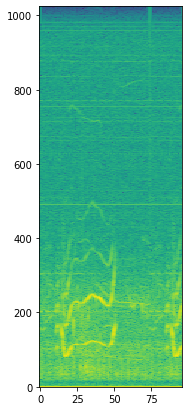

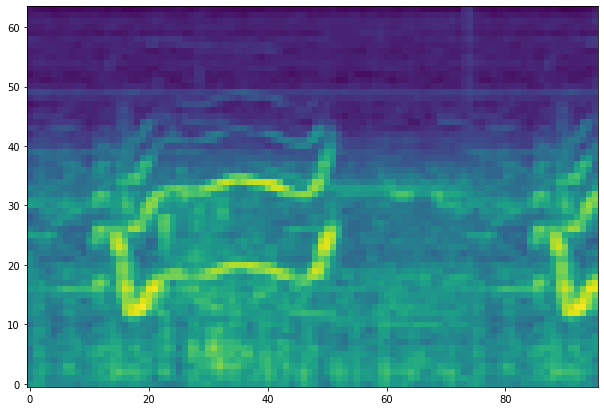

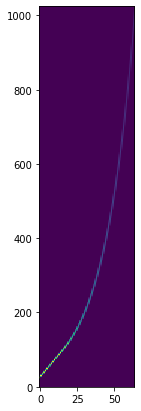

In [77]:
## Used when debugging feature extraction and setting parameters
time_sample = sample
spec = np.abs(librosa.core.stft(time_sample))
# roughly trying out some params based on https://seaworld.org/animals/all-about/killer-whale/communication/
mel_fbank = librosa.filters.mel(sr=params.SAMPLE_RATE,n_fft=2048,n_mels=64,fmin=200,fmax=10000)
spec_mel = np.dot(mel_fbank,spec)
print(spec_mel.shape)

# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(np.log(spec),origin='lower')
ax.set_aspect(0.25)

# plot the melspectrum
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(np.log(spec_mel),origin='lower')
ax.set_aspect(1)

# plot the mel fbank
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_fbank.T,origin='lower')
ax.set_aspect(0.25)

In [78]:
## mean, invstd computation, Two-pass
mean = np.zeros(params.N_MELS)
for i in range(len(wav_dataset)):
    mean += wav_dataset[i][0].mean(axis=0) # can use individual means as they're all the same size
mean /= len(wav_dataset)

In [79]:
variance = np.zeros(params.N_MELS)
for i in range(len(wav_dataset)):
    variance += ((wav_dataset[i][0]-mean)**2).mean(axis=0)
variance /= len(wav_dataset)
invstd = 1/np.sqrt(variance)

In [80]:
# write to file 
np.savetxt('../train_data/mean64.txt',mean)
np.savetxt('../train_data/invstd64.txt',invstd)

# Creating dataset from UI annotations

Standard dataset format understood by the `AudioFileDataset` class consists of:
* A TSV file containing at minimum, columns: `(wav_filename, start_time_s, duration_s)`
* A directory containing all the wav files pointed to by `wav_filename` 

The TSV file only contains entries for the positive segments. All the remaining segments in each `wav_filename` are automatically split up into windows assumed as negative by the `AudioFileDataset` class. 
* If you think there's not enough recall in the labels for a wav file, better to use only the positive segments as separate wav files. 
* If you want to add a wavfile containing only negative examples, add one entry in the TSV containing a tiny segment of length 0.01s. `AudioFileDataset` will automatically ignore this as it's too small and process the rest of the file as negative.

In [213]:
# original scraped WHOIS dataset
ref_tsv = pd.read_csv("../train_data/train.tsv",sep='\t')
ref_wav_dir = "../train_data/wav"
ref_tsv["master_wav"] = ref_tsv["master_wav"].astype(str)
curr_master_wavs = set(ref_tsv.master_wav.unique())
ref_tsv.head()

,wav_filename,start_time_s,duration_s,location,date,master_wav
0,60026.wav,1.000,1.700,"80 mi. south of Martha's Vineyard, Massachusetts",21-Dec-1960,60026
1,60026.wav,8.183,4.141,"80 mi. south of Martha's Vineyard, Massachusetts",21-Dec-1960,60026
2,60026.wav,12.004,5.981,"80 mi. south of Martha's Vineyard, Massachusetts",21-Dec-1960,60026
3,60026.wav,12.883,1.404,"80 mi. south of Martha's Vineyard, Massachusetts",21-Dec-1960,60026
4,60026.wav,18.251,2.789,"80 mi. south of Martha's Vineyard, Massachusetts",21-Dec-1960,60026


In [216]:
annotations_dir = "../data/whoismasterannotations"
positives_dir = "../data/wavmaster_chunked"
negatives_dir = "../data/whoisnegativechunks"
target_data_dir = "../train_data_09222019"
os.makedirs(Path(target_data_dir)/"wav",exist_ok=True)
json_files = glob.glob(annotations_dir+"/*.json")
negative_chunks = glob.glob(negatives_dir+"/*.wav")
annotations = []
tsv_records = []

In [217]:
print("Total all negative chunks",len(negative_chunks))
negatives_in_curr = [ (Path(w).stem.rsplit('_',1)[0] in curr_master_wavs)  for w in negative_chunks ]
negative_chunks = [ w for (f,w) in zip(negatives_in_curr,negative_chunks) if not f ]
print("Total all negative chunks (after filtering)",len(negative_chunks))
print([Path(w).stem for w in negative_chunks])

Total all negative chunks 32
Total all negative chunks (after filtering) 9
['64017_0000', '65009_0006', '65009_000c', '65009_000d', '65009_0011', '65009_0013', '65009_0016', '65009_001a', '65009_001c']


In [218]:
# add chunks containing positive segments from annotations
# also copy wavfiles over to the target directory 
for jsf in json_files:
    with open(jsf) as f: js = f.read().splitlines()
    js = json.loads(js[0].replace("'",'"'))
    master_wav = Path(js["uri"]).stem[:-4]
    annotations.append(js)
    for an in js["annotations"]:
        rcd = {
            "wav_filename": Path(js["uri"]).name,
            "start_time_s": an["start_s"],
            "duration_s": an["duration_s"],
            "location": js["source_guid"],
            "date": master_wav,
            "master_wav": master_wav
        }
        tsv_records.append(rcd)
    src_wav_file = Path(positives_dir)/rcd["wav_filename"]
    tgt_wav_file = Path(target_data_dir)/"wav"
    shutil.copy2(src_wav_file,tgt_wav_file)
# add chunks containing only negatives 
for neg_chunk in negative_chunks:
    master_wav = Path(neg_chunk).stem.rsplit('_',1)[0]
    rcd = {
        "wav_filename": Path(neg_chunk).name,
        "start_time_s": 0.000,
        "duration_s": 0.0100,
        "location": "WHOIS",
        "date": master_wav,
        "master_wav": master_wav
    }
    tsv_records.append(rcd)
    src_wav_file = Path(negatives_dir)/rcd["wav_filename"]
    tgt_wav_file = Path(target_data_dir)/"wav"
    shutil.copy2(src_wav_file,tgt_wav_file)

In [219]:
tsv = pd.DataFrame(tsv_records)
columns = ["wav_filename","start_time_s","duration_s","location","date","master_wav"]
tsv = tsv.reindex(columns=columns)
tsv.head()

,wav_filename,start_time_s,duration_s,location,date,master_wav
0,600120000.wav,31.85,2.45,WHOIS,60012,60012
1,600120000.wav,34.30,2.45,WHOIS,60012,60012
2,600120000.wav,39.20,2.45,WHOIS,60012,60012
3,600120000.wav,41.65,2.45,WHOIS,60012,60012
4,600120000.wav,44.10,2.45,WHOIS,60012,60012


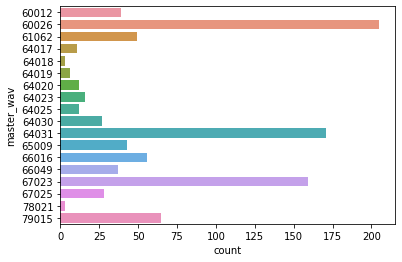

In [220]:
sns.countplot(y=tsv.master_wav)

In [221]:
# select only master wav_ids where there less existing annotations
# also skip 60012 as that was part of the dev set
new_master_wavs_to_add = []
new_master_wavs = set(tsv.master_wav.unique())
for wav_id in new_master_wavs:
    num_existing = len(ref_tsv[ref_tsv["master_wav"] == wav_id ])
    num_new = len(tsv[ tsv["master_wav"] == wav_id ])
    print(wav_id,
          "Existing annotations", num_existing,
          "New annotations", num_new
         )
    if num_new > num_existing and wav_id!="60012":
        new_master_wavs_to_add.append(wav_id)

64025 Existing annotations 9 New annotations 12
61062 Existing annotations 6 New annotations 49
64023 Existing annotations 2 New annotations 16
65009 Existing annotations 0 New annotations 43
64017 Existing annotations 0 New annotations 11
64018 Existing annotations 0 New annotations 3
60012 Existing annotations 0 New annotations 39
64030 Existing annotations 35 New annotations 27
64031 Existing annotations 178 New annotations 171
66049 Existing annotations 3 New annotations 37
66016 Existing annotations 0 New annotations 56
78021 Existing annotations 0 New annotations 3
67023 Existing annotations 0 New annotations 159
79015 Existing annotations 25 New annotations 65
67025 Existing annotations 0 New annotations 28
64019 Existing annotations 0 New annotations 6
64020 Existing annotations 3 New annotations 12
60026 Existing annotations 264 New annotations 205


In [222]:
# we lose approx half the postive annotations :( 
# though still a rich amount negative examples that are not reflected in these counts!
print(len(tsv))
tsv_filtered = tsv[tsv.master_wav.isin(new_master_wavs_to_add)]
print(len(tsv_filtered))

942
500


In [223]:
# join on the location using the master_wav for those which are present 
location_map = {}
for i in range(len(ref_tsv)):
    mwav = ref_tsv.master_wav.iloc[i]
    loc = ref_tsv.location.iloc[i]
    if mwav not in location_map:
        location_map[mwav] = loc
mapped_locations = []
for i in range(len(tsv_filtered)):
    mwav = tsv_filtered.master_wav.iloc[i]
    loc = tsv_filtered.location.iloc[i]
    if mwav in location_map:
        mapped_locations.append(location_map[mwav])
    else:
        mapped_locations.append(loc)
tsv_filtered = tsv_filtered.copy()
tsv_filtered["location"] = mapped_locations

In [226]:
# join on original WHOIS train data TSV and write out TSV 
# also copy over wavfiles from original WHOIS dataset
new_dataset_tsv = pd.concat([ref_tsv,tsv_filtered])
new_dataset_tsv.to_csv(Path(target_data_dir)/"train.tsv",sep='\t',index=False)
for src_wav in glob.glob(ref_wav_dir+"/*.wav"):
    shutil.copy2(src_wav,Path(target_data_dir)/"wav")

## Read with dataloader and compare

This is the original scraped WHOIS dataset. 

In [ ]:
wav_dataset = src.dataloader.AudioFileDataset("../train_data/wav","../train_data/train.tsv")

Total dataset size: 6186


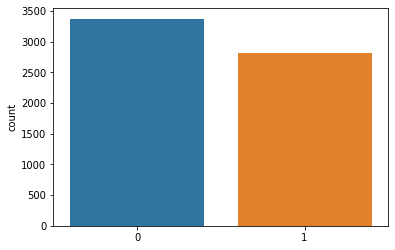

In [236]:
print("Total dataset size:",len(wav_dataset))
labels = [l[2] for l in wav_dataset.windows]
sns.countplot(labels)

This is the new dataset with the first round of annotations added in. This ~2500 new examples i.e. 40% more making it totally ~6hrs of labelled data!

In [ ]:
wav_dataset = src.dataloader.AudioFileDataset("../train_data_09222019/wav","../train_data_09222019/train.tsv")

Total dataset size: 8766


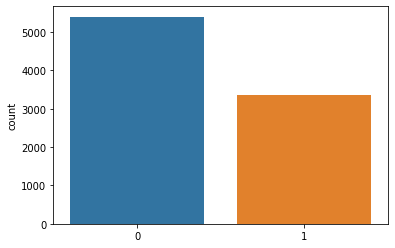

In [243]:
print("Total dataset size:",len(wav_dataset))
labels = [l[2] for l in wav_dataset.windows]
sns.countplot(labels)

In [246]:
## mean, invstd computation, Two-pass
mean = np.zeros(params.N_MELS)
for i in range(len(wav_dataset)):
    mean += wav_dataset[i][0].mean(axis=0) # can use individual means as they're all the same size
mean /= len(wav_dataset)

variance = np.zeros(params.N_MELS)
for i in range(len(wav_dataset)):
    variance += ((wav_dataset[i][0]-mean)**2).mean(axis=0)
variance /= len(wav_dataset)
invstd = 1/np.sqrt(variance)

# write to file 
np.savetxt('../train_data_09222019/mean64.txt',mean)
np.savetxt('../train_data_09222019/invstd64.txt',invstd)